# Best Simulations so far

In [1]:
import meep as mp
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# Simulation parameters
# -----------------------------
resolution = 10  # pixels/um

# Materials
gaas = mp.Medium(epsilon=12)
air = mp.Medium(epsilon=1)

# Disk and waveguide geometry
disk_radius = 3.5
wg_length = 40
wg_width = 0.22
gap = 0.1  # distance between disk and waveguides

# Simulation cell size
cell_x = wg_length + 10
cell_y = 2*(disk_radius + gap + wg_width/2) + 10
cell = mp.Vector3(cell_x, cell_y, 0)

# PML layers
pml_layers = [mp.PML(2.0)]

# -----------------------------
# Geometry: disk + two waveguides
# -----------------------------
geometry = [
    mp.Cylinder(radius=disk_radius, height=mp.inf, center=mp.Vector3(0,0), material=gaas),
    mp.Block(size=mp.Vector3(wg_length, wg_width, mp.inf),
             center=mp.Vector3(0, disk_radius + gap + wg_width/2),
             material=gaas),
    mp.Block(size=mp.Vector3(wg_length, wg_width, mp.inf),
             center=mp.Vector3(0, -disk_radius - gap - wg_width/2),
             material=gaas)
]


-----------
Initializing structure...
time for choose_chunkdivision = 0.000602007 s
Working in 2D dimensions.
Computational cell is 50 x 17.4062 x 0 with resolution 32
     cylinder, center = (0,0,0)
          radius 3.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,3.71,0)
          size (40,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-3.71,0)
          size (40,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 1.73415 s
-----------
on time step 280 (time=4.375), 0.0143245 s/step
on time step 577 (time=9.01562), 0.0134988 s/step
on time step 852 (time=13.3125), 0.0145717 s/step
on time step 1140 (time=17.8125), 0.0139023 s/step
on time step 1428 (time=22.3125), 0.0139324 s/step
on time step 1731 (time=27.0469), 0.0132203 s/step
on time step 2

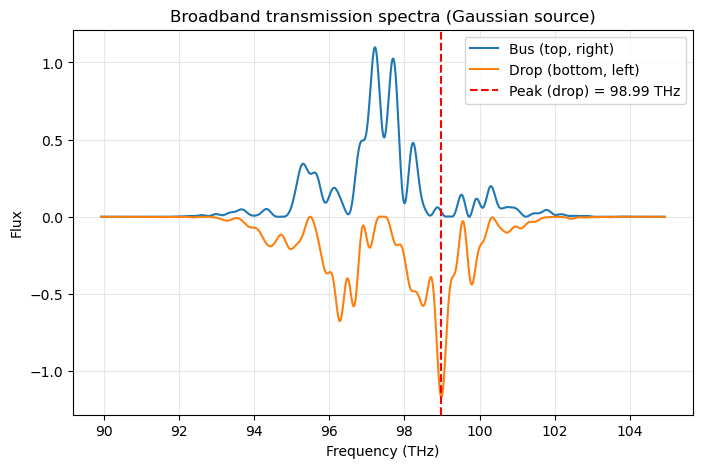

In [11]:

# -----------------------------
# Source (broadband run)
# -----------------------------
source_x = -wg_length/2
source_y = disk_radius + gap + wg_width/2

fmin = 0.3
fmax = 0.35
df = fmax - fmin
nfreq = 1000
resolution = 32  # pixels/um

sources = [mp.Source(mp.GaussianSource(frequency=(fmin+fmax)/2, fwidth=df),
                     component=mp.Ez,
                     center=mp.Vector3(source_x, source_y),
                     size=mp.Vector3(0, wg_width, 0))]

# -----------------------------
# Flux monitors
# -----------------------------
flux_region_bus = mp.FluxRegion(center=mp.Vector3(wg_length/2 - 1,
                                                  disk_radius + gap + wg_width/2),
                                size=mp.Vector3(0, wg_width, 0))

# Drop port moved to left side of lower waveguide (same side as source, opposite waveguide)
flux_region_drop = mp.FluxRegion(center=mp.Vector3(-wg_length/2 + 1,
                                                   -disk_radius - gap - wg_width/2),
                                 size=mp.Vector3(0, wg_width, 0))

# -----------------------------
# First Simulation (spectra)
# -----------------------------
sim = mp.Simulation(cell_size=cell,
                    geometry=geometry,
                    sources=sources,
                    boundary_layers=pml_layers,
                    resolution=resolution)

trans_flux_bus = sim.add_flux((fmin+fmax)/2, df, nfreq, flux_region_bus)
trans_flux_drop = sim.add_flux((fmin+fmax)/2, df, nfreq, flux_region_drop)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(), 5e-3))


frequencies = np.array(mp.get_flux_freqs(trans_flux_bus))
flux_bus = np.array(mp.get_fluxes(trans_flux_bus))
flux_drop = np.array(mp.get_fluxes(trans_flux_drop))

# -----------------------------
# Find resonance from max |flux_drop|
# -----------------------------
res_freq = frequencies[np.argmax(np.abs(flux_drop))]
print(f"Resonance frequency (max |drop port|): {res_freq:.6f} 1/um")

## Conversion: Meep freq (1/um) → THz
c0 = 299792458  # m/s
um_scale = 1e-6  # 1 µm in m
freq_thz = frequencies * c0 / um_scale / 1e12
res_freq_thz = res_freq * c0 / um_scale / 1e12

# Plot
plt.figure(figsize=(8,5))
plt.plot(freq_thz, flux_bus, label='Bus (top, right)')
plt.plot(freq_thz, flux_drop, label='Drop (bottom, left)')
plt.axvline(res_freq_thz, color='r', ls='--', label=f'Peak (drop) = {res_freq_thz:.2f} THz')
plt.xlabel('Frequency (THz)')
plt.ylabel('Flux')
plt.title('Broadband transmission spectra (Gaussian source)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()



In [9]:
# -----------------------------
# Second Simulation (single freq)
# -----------------------------
sources_res = [mp.Source(mp.ContinuousSource(frequency=res_freq),
                         component=mp.Ez,
                         center=mp.Vector3(source_x, source_y),
                         size=mp.Vector3(0, wg_width, 0))]

sim_res = mp.Simulation(cell_size=cell,
                        geometry=geometry,
                        sources=sources_res,
                        boundary_layers=pml_layers,
                        resolution=resolution)

ez_data = []
def store_fields(sim):
    ez_data.append(sim.get_array(center=mp.Vector3(),
                                 size=cell,
                                 component=mp.Ez))

sim_res.run(mp.at_every(20, store_fields), until=400)

# -----------------------------
# Plot Ez snapshots
# -----------------------------
for i, field in enumerate(ez_data):
    if i % 10 == 0:
        plt.figure(figsize=(12,6))
        plt.imshow(np.rot90(field), cmap="RdBu", origin="lower",
                   extent=[-cell_x/2, cell_x/2, -cell_y/2, cell_y/2])
        plt.colorbar(label="Ez field")
        plt.title(f"Ez snapshot {i*20} time units at res_freq={res_freq:.4f}")
        plt.xlabel("x (µm)")
        plt.ylabel("y (µm)")
        plt.show()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000815153 s
Working in 2D dimensions.
Computational cell is 50 x 17.4062 x 0 with resolution 32
     cylinder, center = (0,0,0)
          radius 3.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12,12,12)


     block, center = (0,3.71,0)
          size (40,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-3.71,0)
          size (40,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 2.26616 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

Meep progress: 3.671875/400.0 = 0.9% done in 4.0s, 432.6s to go
on time step 236 (time=3.6875), 0.0169792 s/step
Meep progress: 7.578125/400.0 = 1.9% done in 8.0s, 415.1s to go
on time step 486 (time=7.59375), 0.0160415 s/step
Meep progress: 11.015625/400.0 = 2.8% done in 12.0s, 424.8s to go
on time step 706 (time=11.0312), 0.018234 s/step
Meep progress: 13.921875/400.0 = 3.5% done in 16.0s, 444.8s to go
on time step 892 (time=13.9375), 0.0215847 s/step
Meep progress: 16.828125/400.0 = 4.2% done in 20.1s, 456.7s to go
on time step 1078 (time=16.8438), 0.0215716 s/step
Meep progress: 19.3125/400.0 = 4.8% done in 24.1s, 474.4s to go
on time step 1237 (time=19.3281), 0.0251893 s/step
Meep progress: 22.796875/400.0 = 5.7% done in 28.1s, 464.5s to go
on time step 1460 (time=22.8125), 0.0179983 s/step
Meep progress: 25.9375/400.0 = 6.5% done in 32.1s, 462.6s to go
on time step 1662 (time=25.9688), 0.0198506 s/step
Meep progress: 29.1875/400.0 = 7.3% done in 36.1s, 458.5s to go
on time step 1

KeyboardInterrupt: 